In [167]:
import pandas as pd
ground_truth_dir = "outputs/ground_truths"

ground_truth_df = pd.read_csv(f"{ground_truth_dir}/accident_ground_truths.csv", dtype=str)

ground_truth_df.rename(columns={"Unnamed: 0": "filename"}, inplace=True)

ground_truth_df["filename"] = ground_truth_df["filename"].apply(lambda x: f"{int(x):06d}.mp4")

ground_truth_df.drop(columns=["Other"], inplace=True)
#Remove anything that is not a number in "Number of vehicles in accident"
ground_truth_df["Number of vehicles in accident"] = ground_truth_df["Number of vehicles in accident"].str.extract('(\d+)').fillna(0)

ground_truth_df.head(20)

,filename,Number of vehicles in accident,Accident Type,Person Injury?,Need for ambulance?,Need for firetruck?,Need for Police?,Types of vehicles involved,Fire?,Weather,Low Res/Bad Footage?
0,000000.mp4,0,NaN,No,No,No,No,NaN,No,"Night, Clear",No
1,000001.mp4,3,"Rear-end, spin-out",Yes,No,No,Yes,"Sedan x2, SUV",No,"Snow, Day, Clear",No
2,000002.mp4,6,T-Bone,Yes,Yes,Yes,Yes,"Sedan, Truck x2, SUV x3",Yes,"Day, Clear",No
3,000003.mp4,2,T-bone,Yes,Yes,No,Yes,"sedan, suv",No,"Day, Clear",No
4,000004.mp4,2,T-Bone,Yes,Yes,No,Yes,"suv, truck",No,Night,No
5,000005.mp4,2,T-bone,Yes,Yes,No,Yes,"sedan, suv",No,Night,No
6,000006.mp4,4,T-bone x2,Yes,Yes,No,Yes,"suv, sedan and sedan, suv",No,Night,No
7,000007.mp4,2,T-bone,No,No,No,Yes,"Bus, suv",No,Night,No
8,000008.mp4,2,Light t-bone,No,No,No,Yes,Sedan x2,No,"Day, clear",No
9,000009.mp4,3,T-bone,Yes,Yes,No,Yes,"truck x2, van",No,Day? Perhaps cloudy,No


In [168]:
#Make sure every df is in the same format
def clean_df(df):
    df = df.copy()
    #Clean every single column of special characters, spaces, and convert to lowercase
    for col in df.columns:
        if col == 'filename':
            continue
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
            df[col] = df[col].str.strip()
            df[col] = df[col].str.lower()

    #Number of vehicles in accident should be an integer. If it's not, convert it to NaN
    if 'Number of vehicles in accident' in df.columns:
        #Remove anything that is not a digit or a space
        df['Number of vehicles in accident'] = df['Number of vehicles in accident'].str.replace(r'[^0-9\s]', '', regex=True)
        df['Number of vehicles in accident'] = pd.to_numeric(df['Number of vehicles in accident'], errors='coerce')
        df['Number of vehicles in accident'] = df['Number of vehicles in accident'].fillna(0).astype(int)

    #Yes/No columns should be boolean
    yes_no_columns = ['Person Injury?', 'Need for ambulance?', 'Need for firetruck?', 'Need for Police?', 'Fire?', 'Low Res/Bad Footage?']
    for col in yes_no_columns:
        #If yes is in the column, convert it to True, if no is in the column, convert it to False

        if df[col].str.contains('yes', case=False, na=False).any():
            df[col] = df[col].str.contains('yes', case=False, na=False)
        else:
            df[col] = df[col].str.contains('no', case=False, na=False)
        df[col] = df[col].fillna(False)

    accident_types = ['tbone', 'rear', 'front', 'spinout', 'pedestrian', 'side', 'topple', 'unknown', 'none']
    #For each accident type, grab the string and then check which accident types are present. Then, take that string and convert it to a list
    
    df['Accident Type'] = df['Accident Type'].astype(str)
    for index, row in df.iterrows():
        accidents_occurred = []
        for accident in accident_types:
            if accident in row['Accident Type'].lower():
                accidents_occurred.append(accident)
        df.at[index, 'Accident Type'] = accidents_occurred if accidents_occurred else ['other']


    #Do the same for Weather and Types of vehicles involved
    weather_types = ['rain', 'snow', 'fog', 'clear', 'day', 'night', 'cloudy']

    df['Weather'] = df['Weather'].astype(str)
    for index, row in df.iterrows():
        weather_occurred = []
        for weather in weather_types:
            if weather in row['Weather'].lower():
                weather_occurred.append(weather)
        df.at[index, 'Weather'] = weather_occurred if weather_occurred else ['other']
    #if the column just has "day" or "night", add "clear" to the list
    #df['Weather'] = df['Weather'].apply(lambda x: x + ['clear'] if 'day' in x or 'night' in x else x)

    vehicle_types = ['car', 'truck', 'bus', 'motorcycle', 'motorbike', 'bicycle', 'bike', 'pedestrian', 'suv', 'van', 'sedan', '18wheeler', 'hatchback', 'semi', 'taxi']
    df['Types of vehicles involved'] = df['Types of vehicles involved'].astype(str).replace('car', 'sedan').replace('hatchback', 'sedan').replace('taxi', 'sedan').replace('motorbike', 'motorcycle').replace('bike', 'bicycle').replace('pickup', 'truck').replace('semi', '18wheeler').replace('suv', 'van')

    for index, row in df.iterrows():
        vehicles_occurred = []
        for vehicle in vehicle_types:
            if vehicle in row['Types of vehicles involved'].lower():
                vehicles_occurred.append(vehicle)
        df.at[index, 'Types of vehicles involved'] = vehicles_occurred if vehicles_occurred else ['other']
    

    return df

In [169]:
#Cleaning the ground truth dataframe
cleaned_ground_truth_df = clean_df(ground_truth_df)
cleaned_ground_truth_df.head()

,filename,Number of vehicles in accident,Accident Type,Person Injury?,Need for ambulance?,Need for firetruck?,Need for Police?,Types of vehicles involved,Fire?,Weather,Low Res/Bad Footage?
0,000000.mp4,0,[other],False,False,False,False,[other],False,"[clear, night]",False
1,000001.mp4,3,"[rear, spinout]",True,False,False,True,"[suv, sedan]",False,"[snow, clear, day]",False
2,000002.mp4,6,[tbone],True,True,True,True,"[truck, suv, sedan]",True,"[clear, day]",False
3,000003.mp4,2,[tbone],True,True,False,True,"[suv, sedan]",False,"[clear, day]",False
4,000004.mp4,2,[tbone],True,True,False,True,"[truck, suv]",False,[night],False


In [170]:
trial_dfs = [pd.read_csv(f"{ground_truth_dir}/ground_truth_{i}.csv", dtype=str) for i in range(1, 6)]

#Cleaning each trial dataframe
cleaned_trial_dfs = [clean_df(trial_df) for trial_df in trial_dfs]
cleaned_trial_dfs[0].head()

,filename,Number of vehicles in accident,Accident Type,Person Injury?,Need for ambulance?,Need for firetruck?,Need for Police?,Types of vehicles involved,Fire?,Weather,Low Res/Bad Footage?
0,000000.mp4,2,[side],True,True,False,True,[motorcycle],False,"[clear, day]",True
1,000001.mp4,3,[rear],False,False,False,True,"[suv, sedan]",False,"[snow, day]",True
2,000002.mp4,4,[tbone],True,True,True,True,"[truck, suv, sedan]",True,"[clear, day]",True
3,000003.mp4,2,[tbone],True,True,False,True,"[truck, van, sedan]",False,"[clear, day]",False
4,000004.mp4,2,[tbone],False,False,False,False,"[suv, sedan]",False,"[clear, night]",True


In [171]:
def combine_dfs(dfs):
    combined_df = dfs[0].copy()

    #For yes/no columns, we will take the majority vote. Any missing values will be treated as False
    yes_no_columns = ['Person Injury?', 'Need for ambulance?', 'Need for firetruck?', 'Need for Police?', 'Fire?', 'Low Res/Bad Footage?']

    for col in yes_no_columns:
        combined_df[col] = combined_df[col].fillna(False)
        for df in dfs[1:]:
            df[col] = df[col].fillna(False)
            combined_df[col] = combined_df[col] | df[col]

    #For Number of vehicles in accident, we will take the average
    if 'Number of vehicles in accident' in combined_df.columns:
        combined_df['Number of vehicles in accident'] = combined_df['Number of vehicles in accident'].fillna(0)
        for df in dfs[1:]:
            df['Number of vehicles in accident'] = df['Number of vehicles in accident'].fillna(0)
            combined_df['Number of vehicles in accident'] += df['Number of vehicles in accident']
        combined_df['Number of vehicles in accident'] /= len(dfs)
        combined_df['Number of vehicles in accident'] = combined_df['Number of vehicles in accident'].round().astype(int)

    #For Accident Type, Weather, and Types of vehicles involved, we will include every element that appears in the dataframes in at least 40% of the trials

    num_threshold = len(dfs) * 0.4

    for i, _ in combined_df.iterrows():
        accident_types = []
        weather_types = []
        vehicle_types = []

        for df in dfs:
            accident_types.extend(df.at[i, 'Accident Type'])
            weather_types.extend(df.at[i, 'Weather'])
            vehicle_types.extend(df.at[i, 'Types of vehicles involved'])

        #Count occurrences
        accident_count = pd.Series(accident_types).value_counts()
        weather_count = pd.Series(weather_types).value_counts()
        vehicle_count = pd.Series(vehicle_types).value_counts()

        #Filter based on threshold
        combined_df.at[i, 'Accident Type'] = accident_count[accident_count >= num_threshold].index.tolist() or ['other']
        combined_df.at[i, 'Weather'] = weather_count[weather_count >= num_threshold].index.tolist() or ['other']
        combined_df.at[i, 'Types of vehicles involved'] = vehicle_count[vehicle_count >= num_threshold].index.tolist() or ['other']

        #sort all of the lists
        combined_df.at[i, 'Accident Type'].sort()
        combined_df.at[i, 'Weather'].sort()
        combined_df.at[i, 'Types of vehicles involved'].sort()

    return combined_df

In [172]:
combined_df = combine_dfs(cleaned_trial_dfs)
combined_df.head()

,filename,Number of vehicles in accident,Accident Type,Person Injury?,Need for ambulance?,Need for firetruck?,Need for Police?,Types of vehicles involved,Fire?,Weather,Low Res/Bad Footage?
0,000000.mp4,2,[side],True,True,False,True,[motorcycle],False,"[clear, day]",True
1,000001.mp4,4,[rear],True,True,False,True,"[sedan, suv]",False,"[day, snow]",True
2,000002.mp4,4,[tbone],True,True,True,True,"[sedan, suv, truck]",True,"[clear, day]",True
3,000003.mp4,2,[tbone],True,True,False,True,"[sedan, truck, van]",False,"[clear, day]",False
4,000004.mp4,2,[tbone],False,False,False,True,"[sedan, suv, truck]",False,"[clear, night]",True


In [173]:
#Now, let's compare to the ground truth dataframe

def compare_dfs(expected_df, actual_df):
    comparison = expected_df.copy()
    # Filter out the filename column to only contain filename columns that are in BOTH
    comparison = comparison[comparison['filename'].isin(actual_df['filename'])]
    actual_df = actual_df[actual_df['filename'].isin(comparison['filename'])]

    for col in expected_df.columns:
        if col == 'filename':
            continue
        if expected_df[col].dtype == 'object':
            comparison[col] = expected_df[col] == actual_df[col]
        else:
            comparison[col] = expected_df[col].astype(str) == actual_df[col].astype(str)
    return comparison

In [174]:
compare_df = compare_dfs(cleaned_ground_truth_df, combined_df)
compare_df.head(20)

,filename,Number of vehicles in accident,Accident Type,Person Injury?,Need for ambulance?,Need for firetruck?,Need for Police?,Types of vehicles involved,Fire?,Weather,Low Res/Bad Footage?
0,000000.mp4,False,False,False,False,True,False,False,True,False,False
1,000001.mp4,False,False,True,False,True,True,False,True,False,False
2,000002.mp4,False,True,True,True,True,True,False,True,True,False
3,000003.mp4,True,True,True,True,True,True,False,True,True,True
4,000004.mp4,True,True,False,False,True,True,False,True,False,False
5,000005.mp4,True,False,True,True,True,True,False,False,False,False
6,000006.mp4,False,True,True,True,True,True,False,True,False,False
7,000007.mp4,True,True,False,False,True,True,False,True,False,False
8,000008.mp4,False,False,True,True,True,False,True,True,False,False
9,000009.mp4,False,False,False,False,True,False,False,True,False,False


Number of vehicles in accident    0.517413
Accident Type                     0.298507
Person Injury?                    0.587065
Need for ambulance?               0.582090
Need for firetruck?               0.850746
Need for Police?                  0.646766
Types of vehicles involved        0.114428
Fire?                             0.955224
Weather                           0.363184
dtype: float64


C:\Users\ryana\AppData\Local\Temp\ipykernel_36924\3408499964.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


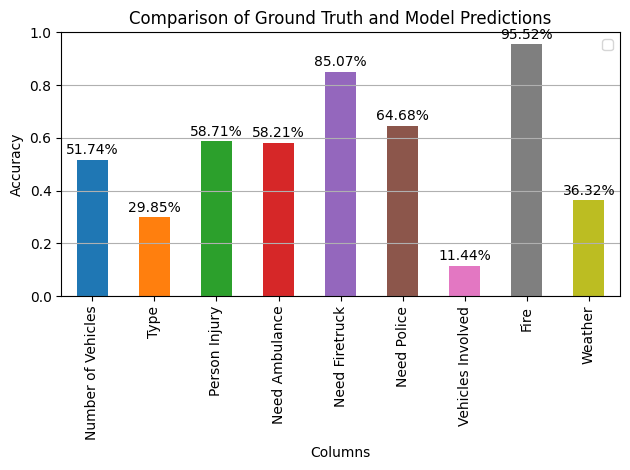

In [175]:
#Create a bar plot of the comparison results, showing the percentage of correct answers for each column
import matplotlib.pyplot as plt

def plot_comparison_results(comparison_df):
    #drop the filename column for accuracy
    accuracy = comparison_df.drop(columns=['filename', 'Low Res/Bad Footage?']).mean()
    print(accuracy)
    # Different colors for each column
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    accuracy.plot(kind='bar', color=colors)
    plt.title('Comparison of Ground Truth and Model Predictions')
    # x-ticks with shorter labels that I will create
    xlabels = ["Number of Vehicles", "Type", "Person Injury", "Need Ambulance", "Need Firetruck", "Need Police", "Vehicles Involved", "Fire", "Weather"]
    plt.xticks(ticks=range(len(accuracy)), labels=xlabels, rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    #include their percentage in the bar
    for i, v in enumerate(accuracy):
        plt.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.legend()
    plt.show()

plot_comparison_results(compare_df)

